In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSCanonical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [12]:
data = pd.read_csv('f_72_pos.csv', index_col=0, dtype={'Disease': str})

In [13]:
feature_data = data.T[['npeaks','pcgroup','drt']].T.drop('Disease', axis=1)
data_d = data.T.drop(labels=['npeaks','pcgroup', 'drt'], axis=1).T

In [14]:
(X,y) = (data_d.drop('Disease', axis=1), data_d['Disease'])
dummies=pd.get_dummies(y)
y = dummies.iloc[:,0].values

In [15]:
feature_scaler = StandardScaler()
feature_data_scaled = feature_scaler.fit_transform(feature_data.T[['npeaks','drt']])
feature_data.T[['npeaks', 'drt']] = feature_data_scaled 

In [16]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0, drt = 0, group=False, log_scale=True)
scaler = StandardScaler()
pca = PCA(n_components=2)
estimators = [('select_features',feature_selector),('scale',scaler)]
pipe = Pipeline(estimators)
X_pca = pipe.fit_transform(X)
X_pca = pca.fit_transform(X_pca)

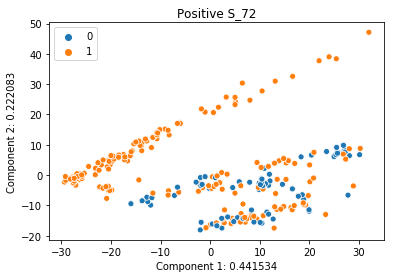

In [17]:
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue = y)
plt.xlabel('Component 1: %f' %pca.explained_variance_ratio_[0])
plt.ylabel('Component 2: %f' %pca.explained_variance_ratio_[1])
plt.title('Positive S_72')
plt.savefig('s_72_pos_clustering.png', format='png')
plt.show()

In [84]:
from sklearn.cross_validation import train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [8]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_data, npeaks=0, drt=0, group=False, log_scale=False):
        self.npeaks = npeaks
        self.drt = drt
        self.group = group
        self.feature_data = feature_data
        self.log_scale = log_scale
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, data):
        if self.log_scale:
            data = data.fillna(1).replace(0,1).apply(np.log10)
        else:
            data = data.fillna(0)
        data = data.astype(float)
        data = pd.concat([data,feature_data], axis=0)
        data = data.T
        index_to_drop=[]
        for index,row in data.iterrows():
            npeaks_data = row['npeaks']
            drt_data = row['drt']
            if npeaks_data<self.npeaks or drt_data<self.drt:
                index_to_drop.append(index)
        data = data.drop(index_to_drop).drop(['npeaks','drt'], axis=1)
        if self.group:
            data = data.astype(float).groupby('pcgroup').mean().T.values
        else:
            data = data.astype(float).drop('pcgroup', axis=1).T.values
        return data

In [73]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0, drt = 0, group=False, log_scale=True)
scaler = StandardScaler()
pca = None
clf = SVC(kernel='linear', C=10000)
estimators = [('select_features',feature_selector),('scale',scaler), ('reduce_dim',pca), ('clf',clf)]
pipe_SVC = Pipeline(estimators)

In [74]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0, drt = 0, group=False, log_scale=True)
scaler = StandardScaler()
pca = PCA(None)
clf = LogisticRegression(penalty='l1', C=10000)
estimators = [('select_features',feature_selector),('scale',scaler), ('reduce_dim',pca), ('clf',clf)]
pipe_log = Pipeline(estimators)

In [75]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0.5, drt = 0.5, group=True, log_scale=True)
scaler = StandardScaler()
pca = None
clf = RandomForestClassifier(n_estimators=100)
estimators = [('select_features',feature_selector),('scale',scaler), ('reduce_dim',pca), ('clf',clf)]
pipe_forest = Pipeline(estimators)

In [76]:
pipes = [pipe_log]
score_results = pd.DataFrame(index=['SVC', 'Log Reg', 'Random Forest'])
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    scores = []
    for pipe in pipes:
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_true=y_test, y_pred=y_pred)
        scores.append(score)
    score_results[i] = scores

In [77]:
score_results

,0,1,2,3,4,5,6,7,8,9
SVC,0.765625,0.890625,0.781250,0.875000,0.796875,0.781250,0.75000,0.890625,0.812500,0.875000
Log Reg,0.781250,0.875000,0.812500,0.828125,0.796875,0.828125,0.75000,0.875000,0.843750,0.859375
Random Forest,0.796875,0.859375,0.734375,0.812500,0.812500,0.796875,0.90625,0.843750,0.796875,0.812500


In [78]:
score_results.T.to_csv('S_72_Results.csv')

In [86]:
np.sum(y_test)/len(y_test)

0.66666666666666663

In [92]:
data

,0,1,2,3,4,5,6,7,8,9,...,10937,10938,10939,10940,10941,10942,10943,10944,10945,Disease
new_index,,,,,,,,,,,,,,,,,,,,,
npeaks,260.000000,18.000000,388.000000,84.000000,512.000000,55.000000,315.000000,438.000000,39.000000,182.000000,...,25.000000,186.000000,129.000000,126.000000,69.000000,32.000000,48.000000,73.000000,15.000000,NaN
20120829_07,4482.306696,407.026937,3671.023280,6326.444127,6176.960779,533.566126,18457.147389,4475.879429,1412.477267,727.531305,...,5125.633859,11959.224890,25885.011720,7409.449130,6441.981480,2778.569777,2722.804843,1438.287596,425.789796,Normal Control
20120829_08,2507.016866,51.223223,3250.532516,6517.229939,4384.859164,517.620675,10634.743875,6011.255849,850.188259,1016.010771,...,1565.600542,11029.358617,41771.943296,7158.105255,8263.175164,2517.060303,2331.967090,2453.680447,958.290035,Normal Control
20120829_09,3298.279888,4.207383,7994.550628,9881.679337,5931.926022,483.420412,14689.373363,4546.744792,874.313742,942.372976,...,2721.170712,10441.486754,25155.939442,6911.772264,6635.633969,2369.770884,1620.746767,2590.317375,1443.061907,Normal Control
20120829_100,1754.610875,262.214364,1704.330766,7109.081357,3797.103999,439.296378,8886.156649,5029.881452,456.016041,1324.177912,...,489.110391,274.325861,6152.385421,126.472639,1370.217032,55.464561,95.711226,146.399639,48.009501,Normal Control
20120829_101,1495.629954,111.669940,1964.825924,6670.934662,5255.664671,285.330579,8409.275421,4028.254929,342.783689,1015.894323,...,69.748743,380.941088,4010.651834,117.559082,901.017850,69.905039,58.635414,246.884975,102.900575,Normal Control
20120829_102,3020.056881,157.997894,1634.872880,7136.842230,5181.616149,408.464567,12003.358259,5873.786271,367.426791,979.468250,...,132.173092,387.813973,5939.967360,172.314002,1177.662920,41.352276,133.906335,78.638973,54.989205,Normal Control
20120829_103,2481.626985,63.160839,1228.986288,7284.388108,5255.639984,383.222101,11254.237522,5130.247114,407.389200,1640.230996,...,42.709583,269.473421,880.127625,178.026024,185.109471,34.460230,73.429248,121.923450,17.799370,Normal Control
20120829_104,2558.772508,105.552976,1993.789212,7162.728250,6179.080154,339.454642,10711.109336,5374.425512,663.868586,894.001937,...,112.544073,287.321289,2015.748492,153.179187,414.202995,95.504067,47.297822,73.635533,75.755301,Normal Control
